In [1]:
import numpy
import math
import cv2
import os

def makeRFSFilters():
    SUP = 49
    SCALES = [1,2,4]
    NORIENT = 6
    
    NROTINV = 2
    NBAR = len(SCALES) * NORIENT 
    NEDGE = len(SCALES) * NORIENT
    NF = NEDGE + NBAR + NROTINV
    F = numpy.zeros((NF, SUP, SUP))
    hsup = 24
    nownum = 0
    x = []
    y = []
    for i in range(-hsup, hsup+1):
        for j in range(-hsup, hsup+1):
            x.append(j)
            y.append(i)
            nownum += 1
    orgpts = numpy.zeros((2, SUP*SUP))
    for i in range(SUP*SUP):
        orgpts[0][i] = x[i]
        orgpts[1][i] = y[i]
    
    count = 0
    for scale in range(len(SCALES)):
        for orient in range(NORIENT):
            angle = math.pi * orient / NORIENT
            Turn = numpy.zeros((2, 2))
            c = math.cos(angle)
            s = math.sin(angle)
            Turn[1, 1] = c
            Turn[0, 0] = c
            Turn[0, 1] = -s
            Turn[1, 0] = s
            Turn = numpy.mat(Turn)
            orgpts = numpy.mat(orgpts)
            rotpts = Turn * orgpts
            #print('r')
            #print(rotpts)
            F[count, :, :] = makefilter(SCALES[scale], 0, 1, rotpts, SUP)
            F[count+NEDGE, :, :] = makefilter(SCALES[scale], 0, 2, rotpts, SUP)
            count = count + 1
            
    F[NBAR+NEDGE, :, :] = normalize(imgGaussian(hsup, 10))
    F[NBAR+NEDGE+1, :, :] = normalize(imgLaplacian(hsup, 10))
    return F

def makefilter(scale, phasex, phasey, pts, sup):
    gx = gaussld(3*scale, 0, pts[0, :], phasex)
    gy = gaussld(1*scale, 0, pts[1, :], phasey)
    f = normalize(numpy.multiply(gx, gy).reshape(sup, sup))
    return f

def gaussld(sigma, mean, x, ord):
    #print('x')
    #print(x)
    x = x - mean
    x = numpy.mat(x)
    num = numpy.multiply(x, x)
    #print('x2')
    #print(x)
    #print(type(num))
    variance = sigma ** 2
    denom = 2 * variance
    #print(denom)
    g = numpy.exp(-1.0*num / denom) / numpy.sqrt(numpy.pi * denom)
    #print('g')
    #print(g)
    if ord == 1:
        g = numpy.multiply(g, x/variance)
    elif ord == 2:
        g = numpy.multiply(g, (num - variance) / (variance**2))
    return g
    
def normalize(f):
    f = f - f.mean()
    f = f / abs(f).sum()
    return f

In [2]:
def imgGaussian(size, sigma):
    '''
    :param sigma: σ标准差
    :return: 高斯滤波器的模板
    '''
    img_h = img_w = size*2+1
    gaussian_mat = numpy.zeros((img_h, img_w))
    for x in range(-size, size + 1):
        for y in range(-size,size + 1):
            gaussian_mat[x + size][y + size] = numpy.exp(-0.5 * (x ** 2 + y ** 2) / (sigma ** 2))
    return gaussian_mat

def imgLaplacian(size, sigma):
    laplacian_mat = -imgGaussian(size, 10)
    laplacian_mat[size+1, size+1] = -(laplacian_mat.sum() - laplacian_mat[size+1, size+1])
    return laplacian_mat

In [3]:
F = makeRFSFilters()

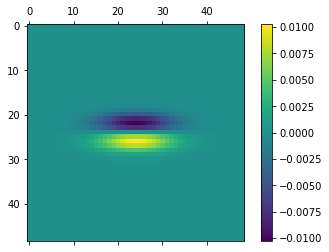

In [136]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(F[6, : ,:])
fig.colorbar(cax)
plt.show()

In [115]:
textures = ['aluminium_foil', 'brown_bread', 'corduroy', 'cotton', 'cracker', 'linen', 'orange_peel', 'sandpaper', 'sponge', 'styrofoam']
array_of_img = []
bin_size = 8
filter_num = 38
def read_directory():
    # this loop is for read each image in this foder,directory_name is the foder name with images.
    directory_name = "KTH_TIPS"
    for i in range(len(textures)):
        array_of_img.append([])
        for filename in os.listdir("KTH_TIPS/"+textures[i]):
            #print(filename) #just for test
            #img is used to store the image data 
            img = cv2.imread(directory_name + "/" + textures[i] + "/" + filename)
            #print(directory_name + "/" + textures[i] + "/" + filename)
            array_of_img[i].append(img)
            cv2.imshow('img', img)

In [116]:
def get_histogram(texture_type, p_id, Kernal_num):
    dstImage = cv2.filter2D(array_of_img[texture_type][p_id],-1,F[Kernal_num, :, :])
    histogram = [0] * int(256 / bin_size)
    rows, cols, _ = dstImage.shape
    for i in range(rows):
        for j in range(cols):
            level = dstImage[i][j][0] / bin_size
            level = int(level)
            histogram[level] += 1
    return histogram

In [122]:
Histogram_list = []

read_directory()

for i in range(filter_num):
    Histogram_list.append([])
    for j in range(len(textures)):
        print(i, j)
        for k in range(9):
            for d_k in range(8):
                Histogram_list[i].append(get_histogram(j, k*9 + d_k, i))

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
3 9
4 0
4 1
4 2
4 3
4 4
4 5
4 6
4 7
4 8
4 9
5 0
5 1
5 2
5 3
5 4
5 5
5 6
5 7
5 8
5 9
6 0
6 1
6 2
6 3
6 4
6 5
6 6
6 7
6 8
6 9
7 0
7 1
7 2
7 3
7 4
7 5
7 6
7 7
7 8
7 9
8 0
8 1
8 2
8 3
8 4
8 5
8 6
8 7
8 8
8 9
9 0
9 1
9 2
9 3
9 4
9 5
9 6
9 7
9 8
9 9
10 0
10 1
10 2
10 3
10 4
10 5
10 6
10 7
10 8
10 9
11 0
11 1
11 2
11 3
11 4
11 5
11 6
11 7
11 8
11 9
12 0
12 1
12 2
12 3
12 4
12 5
12 6
12 7
12 8
12 9
13 0
13 1
13 2
13 3
13 4
13 5
13 6
13 7
13 8
13 9
14 0
14 1
14 2
14 3
14 4
14 5
14 6
14 7
14 8
14 9
15 0
15 1
15 2
15 3
15 4
15 5
15 6
15 7
15 8
15 9
16 0
16 1
16 2
16 3
16 4
16 5
16 6
16 7
16 8
16 9
17 0
17 1
17 2
17 3
17 4
17 5
17 6
17 7
17 8
17 9
18 0
18 1
18 2
18 3
18 4
18 5
18 6
18 7
18 8
18 9
19 0
19 1
19 2
19 3
19 4
19 5
19 6
19 7
19 8
19 9
20 0
20 1
20 2
20 3
20 4
20 5
20 6
20 7
20 8
20 9
21 0
21 1
21 2
21 3
21 4
21 5
21 6
21 7
21 8
21 9


In [137]:
confusion = numpy.zeros((len(textures), len(textures)))
for j in range(len(textures)):
    for kk in range(9):
        k = 9*kk+8
        print(j, k)
        count = [0] * len(textures)
        for i in range(38):
            now_histogram = get_histogram(j, k, i)
            min_d = 1600000000 
            y = 0
            for l in range(len(Histogram_list[i])):
                    now_d = 0
                    #print(now_histogram, Histogram_list[i][l])
                    for m in range(len(now_histogram)):
                        now_d += (now_histogram[m] - Histogram_list[i][l][m]) ** 2
                    #print(now_d)
                    if(min_d > now_d):
                        min_d = now_d
                        y = l / 
                        y = int(y)
                        #print(y)
            count[y] += 1
        count = numpy.array(count)
        print(count)
        #print(count.max(0))
        predict = numpy.argmax(count)
        print(j, predict)
        confusion[j][predict] += 1
        

0 8
[33  0  0  0  5  0  0  0  0  0]
0 0
0 17
[37  0  0  0  1  0  0  0  0  0]
0 0
0 26
[36  0  0  0  2  0  0  0  0  0]
0 0
0 35
[38  0  0  0  0  0  0  0  0  0]
0 0
0 44
[31  0  1  0  5  1  0  0  0  0]
0 0
0 53
[38  0  0  0  0  0  0  0  0  0]
0 0
0 62
[34  2  0  0  2  0  0  0  0  0]
0 0
0 71
[34  2  0  0  2  0  0  0  0  0]
0 0
0 80
[38  0  0  0  0  0  0  0  0  0]
0 0
1 8
[ 0 17  2  0  4  2  1  1  5  6]
1 1
1 17
[ 0 30  0  0  8  0  0  0  0  0]
1 1
1 26
[ 0 38  0  0  0  0  0  0  0  0]
1 1
1 35
[ 4 27  0  1  4  1  0  0  1  0]
1 1
1 44
[ 0 35  0  0  3  0  0  0  0  0]
1 1
1 53
[ 0 31  0  0  7  0  0  0  0  0]
1 1
1 62
[ 0 11  7  3  1  1  5  5  2  3]
1 1
1 71
[ 1 17  4  1  9  1  0  1  3  1]
1 1
1 80
[ 0 38  0  0  0  0  0  0  0  0]
1 1
2 8
[ 0  0 13  4  0  4  3  8  2  4]
2 2
2 17
[ 1  5 10  2  6  4  1  2  2  5]
2 2
2 26
[0 0 6 9 0 8 6 4 1 4]
2 3
2 35
[ 0  0 13  2  0  5  2  9  3  4]
2 2
2 44
[ 0  2 18  4  0  2  2  5  4  1]
2 2
2 53
[ 0  1 14  3  2  7  0  2  4  5]
2 2
2 62
[ 0  1 11  4  1  6  3  8

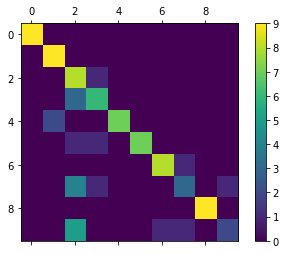

83.95061728395062


In [138]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion)
fig.colorbar(cax)
plt.show()
correct = 0
for i in range(10):
    correct += confusion[i][i]
print(100.0 * correct / 81)

In [2]:
y = 1 /

SyntaxError: invalid syntax (<ipython-input-2-8d7c31afc945>, line 1)